# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [1]:
import artm

In [2]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [3]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [4]:
# Ваш код
#the_number_of_symbols_to_limit_the_line_length_according_to_PEP8_is________79
batch_vectorizer = artm.BatchVectorizer(data_path='../data/lectures.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='lectures_batches')

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [5]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model = artm.ARTM(num_topics=T,
                  topic_names=topic_names,
                  class_ids={'text':1, 'author':1},
                  cache_theta=True,
                  reuse_theta=True,
                  num_document_passes=1)

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [6]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

model.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [7]:
model.topic_names[29:]

['bcg']

In [8]:
# Ваш код
model.scores.add(artm.TopTokensScore(name='top_words', num_tokens=15,
                                           class_id='text'))
model.scores.add(artm.TopTokensScore(name='top_authors', num_tokens=15,
                                           class_id='author'))

# Code from tutorial to monitor topics phi sparsity.
model.scores.add(
    artm.SparsityPhiScore(
        name='sparsity_phi_score_sbj',
        class_id='text',
        topic_names=model.topic_names[0:29]
    )
)
model.scores.add(
    artm.SparsityPhiScore(
        name='sparsity_phi_score_bcg',
        class_id='text',
        topic_names=model.topic_names[29:]
    )
)
model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))


##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [9]:
# Ваш код
model.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SmoothSparsePhi_bcg',
        tau=1e5,
        class_ids=['text'],
        dictionary=dictionary,
        topic_names=model.topic_names[29:]
    )
)

In [10]:
# model.regularizers['SmoothSparsePhi_bcg'].tau = 1e5

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [11]:
%%time
np.random.seed(1)
# model.num_document_passes = 1
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer,
                        num_collection_passes=30)

CPU times: user 24 s, sys: 1.75 s, total: 25.7 s
Wall time: 19.3 s


sbj sparsity: 0.7770271301269531
bcg sparsity: 0.0


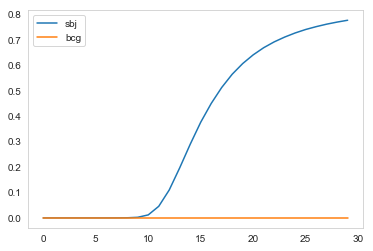

In [12]:
plt.plot(model.score_tracker['sparsity_phi_score_sbj'].value, label='sbj')
plt.plot(model.score_tracker['sparsity_phi_score_bcg'].value, label='bcg')
plt.legend(loc='best');
print('sbj sparsity:', model.score_tracker['sparsity_phi_score_sbj'].last_value)
print('bcg sparsity:', model.score_tracker['sparsity_phi_score_bcg'].last_value)


Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [13]:
# Ваш код
model.regularizers.add(
    artm.SmoothSparsePhiRegularizer(
        name='SmoothSparsePhi_sbj',
        tau=-1e5,
        class_ids=['text'],
        dictionary='dictionary',
        topic_names=model.topic_names[:29]
    )
)

In [14]:
model.regularizers['SmoothSparsePhi_sbj'].tau = -1e5

Выполните еще 15 проходов по коллекции.

In [15]:
%%time
np.random.seed(1)
# Ваш код
model.fit_offline(batch_vectorizer=batch_vectorizer,
                        num_collection_passes=15)

CPU times: user 12.4 s, sys: 843 ms, total: 13.3 s
Wall time: 10.1 s


sbj sparsity: 0.9596297740936279
bcg sparsity: 0.0


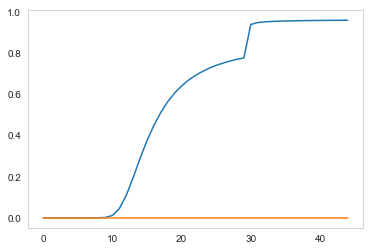

In [16]:
plt.plot(model.score_tracker['sparsity_phi_score_sbj'].value)
plt.plot(model.score_tracker['sparsity_phi_score_bcg'].value);
print('sbj sparsity:', model.score_tracker['sparsity_phi_score_sbj'].last_value)
print('bcg sparsity:', model.score_tracker['sparsity_phi_score_bcg'].last_value)


##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [17]:
len(model.score_tracker['top_words'].last_tokens.keys())

30

In [18]:
for topic in model.topic_names:
    token_dicts = model.score_tracker['top_words'].last_tokens
    print(topic + ':', end=' ')
    for token in token_dicts[topic]:
        print(token, end=' ')
    print('\n')

sbj0: церковь власть русь средневековый император святой римский сага князь папа король александр византийский церковный рим 

sbj1: планета земля атмосфера солнце солнечный белый газ карлик образовываться вокруг спутник звезда вода поверхность кислород 

sbj2: система состояние трудность двигаться частота поведение искусственный точность относительность движение переход тест час самка самец 

sbj3: культура понятие культурный восприятие сознание феномен личность ощущение воспринимать чувство переживание повседневный этика лосев глобальный 

sbj4: право литература литературный искусство юрист должник собственность обязательство римский владение произведение писатель юридический собственник исполнение 

sbj5: материал структура молекула свойство углерод вещество применение полимер поверхность кристалл металл электронный алмаз углеродный твердый 

sbj6: фильм книга автор кино театр жанр кинематограф анекдот тема документ пьеса культовый академия герой екатерина 

sbj7: смерть ритуал терр

In [19]:
for topic in model.topic_names:
    token_dicts = model.score_tracker['top_authors'].last_tokens
    print(topic + ':', end=' ')
    for token in token_dicts[topic]:
        print(token, end=' ')
    print('\n')

sbj0: Александр_Марей Фёдор_Успенский Татьяна_Бобровникова Павел_Уваров Игорь_Данилевский Алексей_Юдин Ольга_Вайнштейн Елена_Уханова Ольга_Брилева Владимир_Петрухин Елена_Браун Григорий_Бондаренко Раиса_Кирсанова Екатерина_Болтунова Ольга_Тогоева 

sbj1: Сергей_Попов Дмитрий_Вибе Кирилл_Еськов Дмитрий_Титов Валерий_Сулейманов Зоригто_Намсараев Сергей_Наугольных Александр_Марков Наталья_Новикова Александр_Слободкин Елизавета_Ривкина Роман_Рафиков Сергей_Писарев Дмитрий_Лось Юлия_Краус 

sbj2: Елена_Брызгалина Михаил_Пантелеев Александр_Поддьяков Владимир_Мележик Эмиль_Ахмедов Даниэль_Сельва Антон_Суворов Виталий_Пальчиков Михаил_Фейгельман Василий_Климов Юджин_Ползик Алексей_Желтиков Владимир_Редько Илья_Щуров Кристофер_Уиншип 

sbj3: Пётр_Турчин Сергей_Арутюнов Алексей_Руткевич Владимир_Миронов Татьяна_Смоктунович Андрей_Лосев Константин_Анохин Кирилл_Разлогов Павел_Степанцов Дмитрий_Иванов Александр_Кислов Павел_Умрюхин Фёдор_Гиренок Светлана_Кузнецова Андрей_Лукашов 

sbj4: Дмитрий_Д

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [20]:
sbj_topic_labels = [
    '0Византия',
    "1Космология",
    "2Физика. Относительность",
    "3Философия. Культура",
    "4Имущественное право",
    "5Углеродные структуры",
    "6Кинематограф",
    "7Французская революция",
    "8Химия",
    "9Физика элементарных частиц",
    "10Вторая мировая война. Германия",
    "11Старение",
    "12Рак. Болезнь",
    "13Христианство и Восток",
    "14Космические излучения",
    "15Когнитивная психология",
    "16Африка. Происхождение человека",
    "17История философии",
    "18Лингвистика. Разбор слова",
    "19Французская революция",
    "20Развитие ребенка в гороской среде",
    "21Диагностика заболеваний",
    "22Социология",
    "23Биоинформатика",
    "24История до н.э.",
    "25Лингвика. Диалекты",
    "26Сталинский период правления",
    "27Генетика",
    "28Сверхпроводники"
]   # запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [21]:
model.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = pd.DataFrame(model.get_phi(class_ids=['author']))
theta = model.get_theta()
phi_a.columns = topic_labels
theta.index = topic_labels

In [39]:
phi_a.head()

,0Византия,1Космология,2Физика. Относительность,3Философия. Культура,4Имущественное право,5Углеродные структуры,6Кинематограф,7Французская революция,8Химия,9Физика элементарных частиц,...,20Развитие ребенка в гороской среде,21Диагностика заболеваний,22Социология,23Биоинформатика,24История до н.э.,25Лингвика. Диалекты,26Сталинский период правления,27Генетика,28Сверхпроводники,Фоновая тема
Дэвид_Гросс,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.011675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Павел_Степанцов,0.0,0.0,0.0,0.041270,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ирина_Каспэ,0.0,0.0,0.0,0.020635,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Александр_Беленький,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.042619,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Татьяна_Гусарова,0.0,0.0,0.0,0.000000,0.020807,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
theta.head()

,http://postnauka.ru/video/10006,http://postnauka.ru/video/10379,http://postnauka.ru/video/10380,http://postnauka.ru/video/10381,http://postnauka.ru/video/10382,http://postnauka.ru/video/10383,http://postnauka.ru/video/10384,http://postnauka.ru/video/10385,http://postnauka.ru/video/10473,http://postnauka.ru/video/10475,...,http://postnauka.ru/video/9874,http://postnauka.ru/video/9876,http://postnauka.ru/video/9968,http://postnauka.ru/video/9992,http://postnauka.ru/video/9993,http://postnauka.ru/video/9994,http://postnauka.ru/video/9995,http://postnauka.ru/video/9996,http://postnauka.ru/video/9997,http://postnauka.ru/video/9998
0Византия,0.009897,0.00000,0.000000,0.168155,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.250651,0.014779,0.000000,0.000000,2.470037e-08,0.0,0.000000,0.000000
1Космология,0.000000,0.00000,0.019840,0.000000,0.0,0.000000,0.006378,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.000000,0.000013,0.006668,2.639933e-02,0.0,0.000000,0.000000
2Физика. Относительность,0.000000,0.00000,0.000000,0.057611,0.0,0.030574,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.000000,0.000000,0.004283,0.000000,3.635115e-07,0.0,0.000000,0.000000
3Философия. Культура,0.000000,0.03935,0.043017,0.000000,0.0,0.000000,0.004350,0.054791,0.0,0.0,...,0.14504,0.0,0.000000,0.000000,0.000000,0.027957,3.264710e-04,0.0,0.053268,0.021815
4Имущественное право,0.114728,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.00000,0.0,0.063707,0.196853,0.000000,0.000000,0.000000e+00,0.0,0.000000,0.000000


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

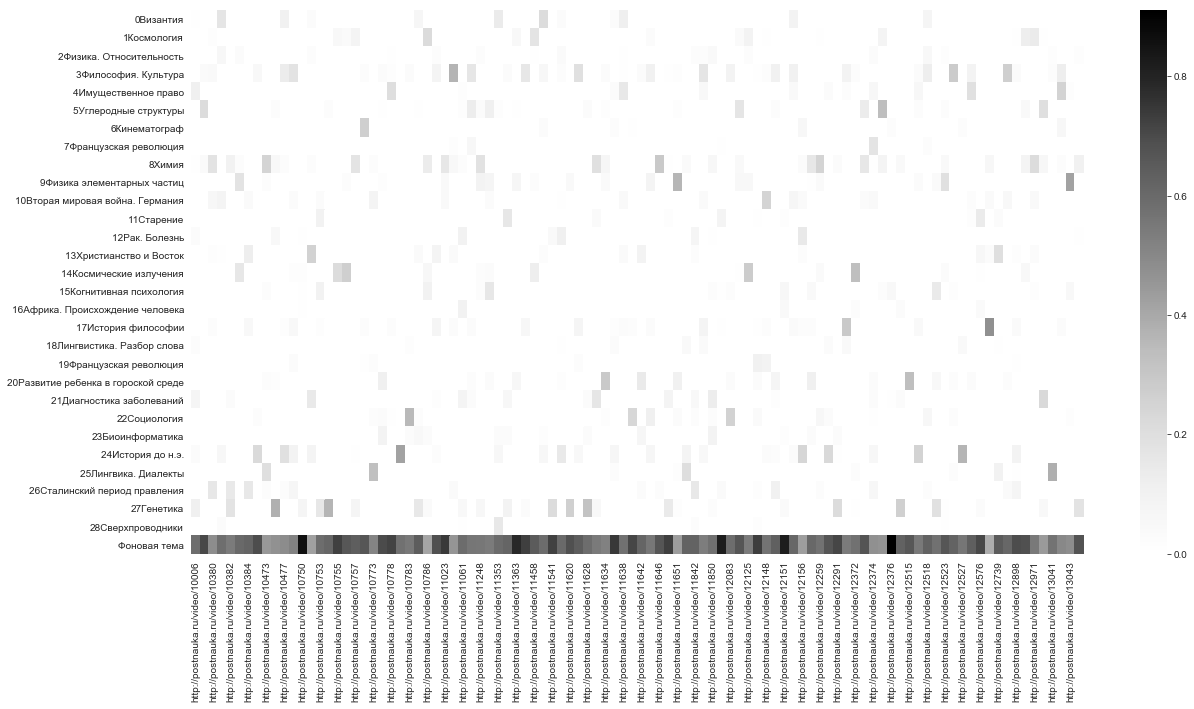

In [23]:
# Ваш код
plt.figure(figsize=(20,10))
seaborn.heatmap(theta.iloc[:,:100], cmap='Greys');

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [24]:
# Ваш код
topic_prob = theta.sum(axis=1) / sum(theta.sum(axis=1))
print(topic_prob)

0Византия                              0.011110
1Космология                            0.011569
2Физика. Относительность               0.008046
3Философия. Культура                   0.012837
4Имущественное право                   0.008411
5Углеродные структуры                  0.010271
6Кинематограф                          0.006308
7Французская революция                 0.004612
8Химия                                 0.013171
9Физика элементарных частиц            0.020993
10Вторая мировая война. Германия       0.014646
11Старение                             0.006417
12Рак. Болезнь                         0.007678
13Христианство и Восток                0.013999
14Космические излучения                0.018465
15Когнитивная психология               0.011922
16Африка. Происхождение человека       0.004228
17История философии                    0.015143
18Лингвистика. Разбор слова            0.008967
19Французская революция                0.005973
20Развитие ребенка в гороской среде    0

Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [25]:
topic_prob.sort_values(ascending=False)[-3:].index

Index(['28Сверхпроводники', '7Французская революция',
       '16Африка. Происхождение человека'],
      dtype='object')

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

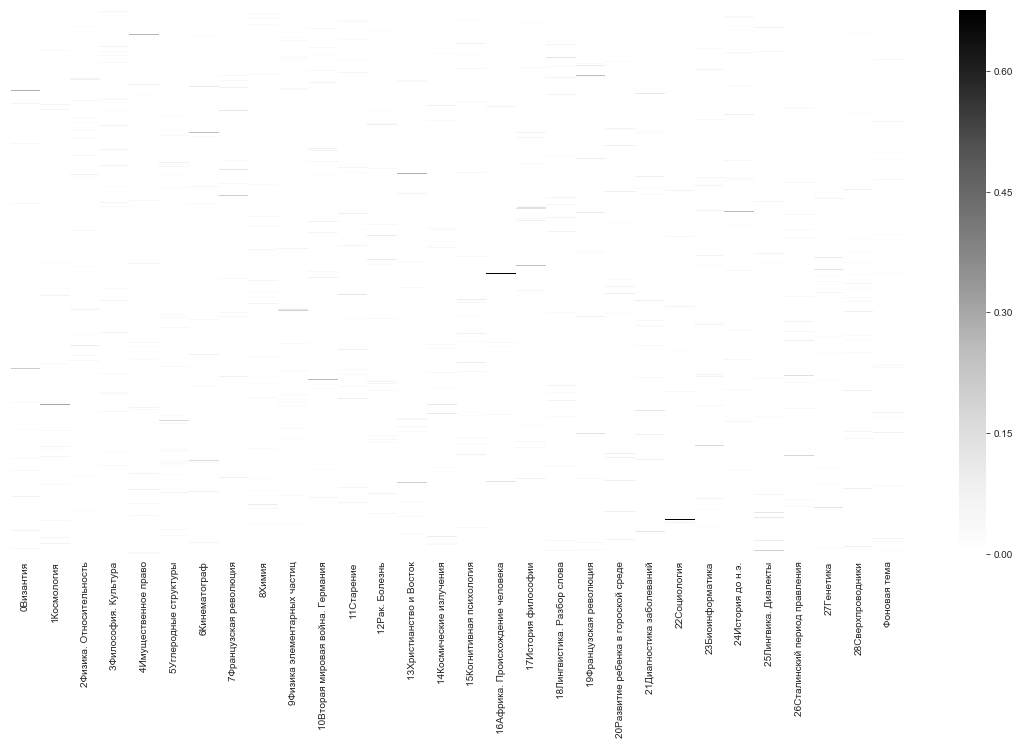

In [26]:
# Ваш код
figure = plt.figure(figsize=(20,10))
seaborn.heatmap(phi_a, cmap='Greys', yticklabels=False);
#plt.savefig('authors~topic.pdf', dpi=figure.dpi, bbox_inches='tight')

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

In [48]:
author_list = dict()
for author in phi_a.index:
    author_list[author] = []
    for topic in phi_a.columns:
        if phi_a.loc[author, topic] > 0.01:
            author_list[author].append(topic)

In [49]:
author_list

{'Aльберт_Давлетшин': [],
 'Ави_Лёб': ['14Космические излучения'],
 'Александр_Апт': ['8Химия'],
 'Александр_Аузан': ['26Сталинский период правления'],
 'Александр_Баландин': ['9Физика элементарных частиц'],
 'Александр_Беленький': ['8Химия'],
 'Александр_Васильев': ['21Диагностика заболеваний'],
 'Александр_Ватлин': ['10Вторая мировая война. Германия'],
 'Александр_Воеводский': ['17История философии', '24История до н.э.'],
 'Александр_Войскунский': ['15Когнитивная психология'],
 'Александр_Высоковский': ['13Христианство и Восток'],
 'Александр_Габибов': ['8Химия', '21Диагностика заболеваний'],
 'Александр_Гофман': ['3Философия. Культура', '7Французская революция'],
 'Александр_Дмитриев': ['19Французская революция', '28Сверхпроводники'],
 'Александр_Доброхотов': ['Фоновая тема'],
 'Александр_Дьяконов': ['22Социология'],
 'Александр_Жаворонков': ['11Старение', '23Биоинформатика'],
 'Александр_Жданов': ['23Биоинформатика'],
 'Александр_Каменский': ['10Вторая мировая война. Германия'],
 '

In [53]:
for key in author_list.keys():
    if len(author_list[key]) >= 3: 
        print(key)

Дмитрий_Лось
Владимир_Белотелов
Елена_Брызгалина
Ольга_Вайнштейн
Шринивас_Шридхар
Алина_Бодрова


In [29]:
author_list = phi_a.apply(lambda a: sum(a>0.01), axis=1)
author_list[author_list>=3]

Ольга_Вайнштейн       3
Дмитрий_Лось          3
Алина_Бодрова         3
Владимир_Белотелов    3
Елена_Брызгалина      3
Шринивас_Шридхар      3
dtype: int64

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [30]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE

In [31]:
phi_a[phi_a>0].count(axis=1)[:10]

Дэвид_Гросс            1
Павел_Степанцов        1
Ирина_Каспэ            1
Александр_Беленький    1
Татьяна_Гусарова       1
Андрей_Коротаев        1
Галина_Зеленина        3
Ирина_Левонтина        2
Алексей_Малашенко      4
Дэвид_Кларк            2
dtype: int64

In [32]:
# Ваш код
author_profile = (phi_a * topic_prob).divide((phi_a * topic_prob).sum(axis=1), axis=0)
author_profile.head(20)

,0Византия,1Космология,2Физика. Относительность,3Философия. Культура,4Имущественное право,5Углеродные структуры,6Кинематограф,7Французская революция,8Химия,9Физика элементарных частиц,...,20Развитие ребенка в гороской среде,21Диагностика заболеваний,22Социология,23Биоинформатика,24История до н.э.,25Лингвика. Диалекты,26Сталинский период правления,27Генетика,28Сверхпроводники,Фоновая тема
Дэвид_Гросс,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0
Павел_Степанцов,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0
Ирина_Каспэ,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0
Александр_Беленький,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0
Татьяна_Гусарова,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0
Андрей_Коротаев,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0
Галина_Зеленина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000e+00,0.0,0.0,9.999997e-01,0.000000,0.0,0.000000,0.0,0.0
Ирина_Левонтина,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,4.178043e-15,0.0,0.0,1.000000e+00,0.000000,0.0,0.000000,0.0,0.0
Алексей_Малашенко,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.999996,0.0,...,0.000000,0.000000e+00,0.0,0.0,6.868319e-07,0.000000,0.0,0.000000,0.0,0.0
Дэвид_Кларк,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000027,0.000000e+00,0.0,0.0,0.000000e+00,0.000000,0.0,0.000000,0.0,0.0


Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [33]:
# Ваш код
mds = MDS(n_components=2, dissimilarity='precomputed')
authors_vis  = mds.fit_transform(pairwise_distances(author_profile, metric='cosine'))

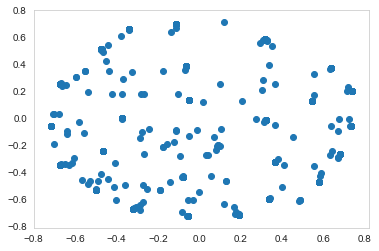

In [34]:
plt.scatter(authors_vis[:,0], authors_vis[:,1]);

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

In [37]:
import scipy.stats as sts
s = sts.norm(scale=0.03)
s.rvs(1)

array([0.05127623])

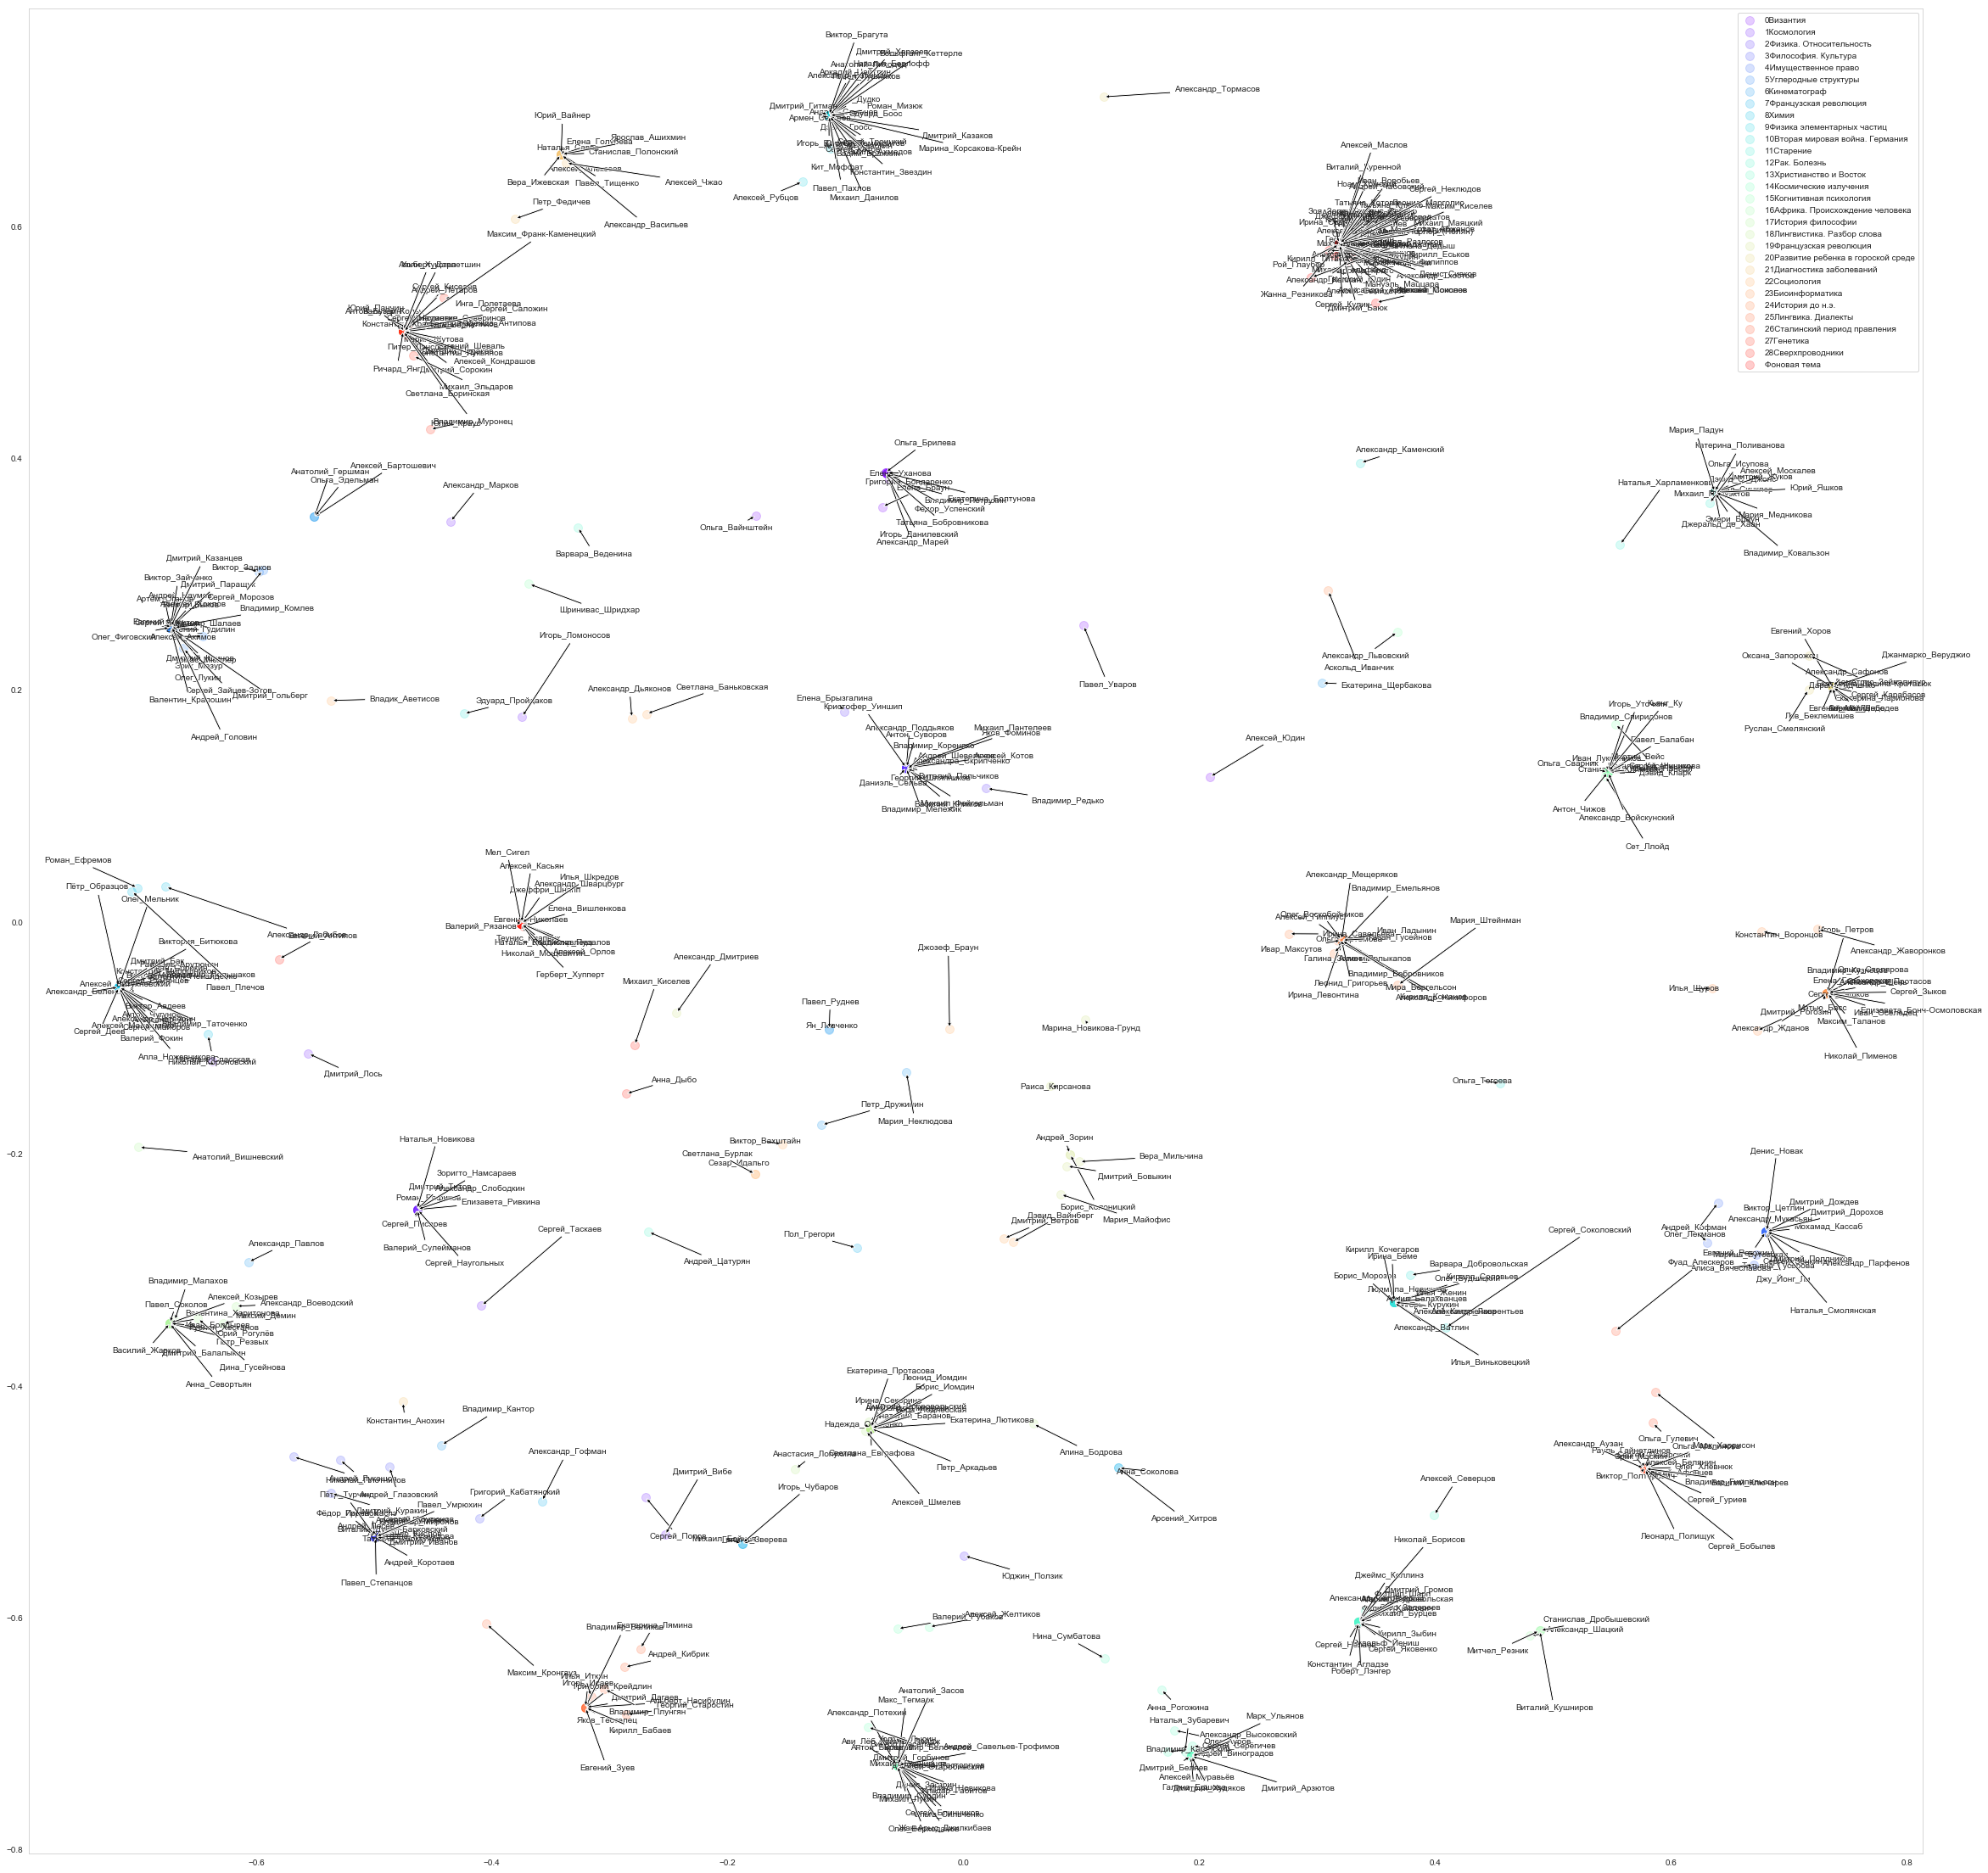

In [38]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T).reshape(T, 1)) # цвета для тем
# Ваш код
color_map = {topic: color for topic, color in zip(topic_labels, colors)}
fig = plt.figure(figsize=(40,40))
for color, topic in zip(colors, topic_labels):
    plt.scatter(
        authors_vis[author_profile.idxmax(axis=1)==topic, 0],
        authors_vis[author_profile.idxmax(axis=1)==topic, 1],
        c=color,
        alpha=0.2,
        label=topic,
        s=100
    )
# texts = [plt.text(point[0], point[1], author) for point, author in zip(authors_vis, author_profile.index)]
# adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))
for point, author in zip(authors_vis, author_profile.index):
    plt.annotate(
        author,
        point,
        xytext=(point[0]+s.rvs(1),
                point[1]+s.rvs(1)),
        arrowprops=dict(facecolor='black',
            arrowstyle="simple"))
plt.legend();
plt.savefig('author_cloud.pdf', bbox_inches='tight', dpi=fig.dpi)

In [43]:
author_profile.idxmax(axis=1)

Дэвид_Гросс                       9Физика элементарных частиц
Павел_Степанцов                          3Философия. Культура
Ирина_Каспэ                              3Философия. Культура
Александр_Беленький                                    8Химия
Татьяна_Гусарова                         4Имущественное право
Андрей_Коротаев                          3Философия. Культура
Галина_Зеленина                             24История до н.э.
Ирина_Левонтина                             24История до н.э.
Алексей_Малашенко                                      8Химия
Дэвид_Кларк                          15Когнитивная психология
Михаил_Полуэктов                                   11Старение
Алексей_Москалев                                   11Старение
Екатерина_Болтунова                                 0Византия
Юрий_Рогулёв                              17История философии
Антон_Чугунов                                          8Химия
Александр_Мещеряков                         24История до н.э.
Алексей_

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [72]:
# Ваш код
topic_profile = theta.div(theta.sum(axis=1), axis=0)

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [73]:
print("http://yandex.ru")   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [74]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [146]:
topic_map={'sbj'+str(num):val for num,val in enumerate(topic_labels[:-1])}
topic_map['bcg']=topic_labels[-1]

top_words = model.score_tracker['top_words'].last_tokens

top_words = {topic_map[key]: top_words[key] for key in top_words.keys()}

In [121]:
def get_page_title(link):
    import requests
    from lxml.html import fromstring
    r = requests.get(link)
    tree = fromstring(r.content)
    title = tree.findtext('.//title')
    return title

In [147]:
# Ваш код
for topic in topic_profile.index:
    display(HTML("<h1>{}</h1>".format(topic.strip(r'[0123456789]'))))
    print(top_words[topic][:10])
    top_videos = topic_profile.loc[topic].sort_values(ascending=False)[:10].index
    for link in top_videos:
        display(HTML(u'<a href="{}">{}</a>'.format(link, get_page_title(link))))
    
    

['церковь', 'власть', 'русь', 'средневековый', 'император', 'святой', 'римский', 'сага', 'князь', 'папа']


['планета', 'земля', 'атмосфера', 'солнце', 'солнечный', 'белый', 'газ', 'карлик', 'образовываться', 'вокруг']


['система', 'состояние', 'трудность', 'двигаться', 'частота', 'поведение', 'искусственный', 'точность', 'относительность', 'движение']


['культура', 'понятие', 'культурный', 'восприятие', 'сознание', 'феномен', 'личность', 'ощущение', 'воспринимать', 'чувство']


['право', 'литература', 'литературный', 'искусство', 'юрист', 'должник', 'собственность', 'обязательство', 'римский', 'владение']


['материал', 'структура', 'молекула', 'свойство', 'углерод', 'вещество', 'применение', 'полимер', 'поверхность', 'кристалл']


['фильм', 'книга', 'автор', 'кино', 'театр', 'жанр', 'кинематограф', 'анекдот', 'тема', 'документ']


['смерть', 'ритуал', 'террор', 'государь', 'правитель', 'обряд', 'идеология', 'служба', 'конвент', 'символический']


['метод', 'химический', 'соединение', 'реакция', 'химия', 'органический', 'лекарство', 'давление', 'синтез', 'разработка']


['частица', 'энергия', 'квантовый', 'поле', 'физика', 'взаимодействие', 'атом', 'магнитный', 'электрон', 'кварк']


['война', 'россия', 'советский', 'русский', 'власть', 'российский', 'германия', 'мировой', 'реформа', 'историк']


['ребенок', 'семья', 'возраст', 'взрослый', 'сон', 'мать', 'родитель', 'кровь', 'старение', 'катастрофа']


['растение', 'ткань', 'опухоль', 'орган', 'рак', 'иммунный', 'озеро', 'сердце', 'мышца', 'нейронный']


['территория', 'христианский', 'империя', 'восток', 'народ', 'древний', 'письменность', 'христианство', 'государство', 'памятник']


['звезда', 'галактика', 'масса', 'вселенная', 'черный', 'свет', 'волна', 'дыра', 'скорость', 'излучение']


['задача', 'информация', 'память', 'данные', 'решение', 'компьютер', 'психология', 'мышление', 'внимание', 'когнитивный']


['раса', 'африка', 'остров', 'америка', 'станислав', 'южный', 'монголоид', 'индия', 'дробышевский', 'нос']


['политический', 'философия', 'государство', 'общество', 'философский', 'философ', 'партия', 'правовой', 'суд', 'платон']


['слово', 'текст', 'русский', 'словарь', 'предложение', 'значение', 'глагол', 'корпус', 'категория', 'лингвистика']


['революция', 'французский', 'свобода', 'франция', 'роман', 'национальный', 'король', 'нация', 'аргумент', 'актер']


['город', 'сеть', 'робот', 'технология', 'городской', 'интернет', 'компания', 'пользователь', 'музей', 'медиа']


['болезнь', 'заболевание', 'пациент', 'лечение', 'врач', 'медицина', 'боль', 'женщина', 'препарат', 'медицинский']


['социальный', 'знание', 'социология', 'социологический', 'дисциплина', 'познание', 'перевод', 'социолог', 'описание', 'обучение']


['микроорганизм', 'матрица', 'алгоритм', 'эмоция', 'схема', 'вычислительный', 'эмоциональный', 'микроб', 'программный', 'глубина']


['исторический', 'бог', 'традиция', 'царь', 'миф', 'греческий', 'представление', 'религия', 'имя', 'мифология']


['язык', 'лингвист', 'языковой', 'гласный', 'английский', 'согласный', 'лингвистический', 'говор', 'звук', 'диалект']


['страна', 'экономический', 'экономика', 'политика', 'сталин', 'идентичность', 'коллективный', 'кризис', 'общественный', 'праздник']


['клетка', 'ген', 'днк', 'организм', 'белок', 'мозг', 'биологический', 'животное', 'генетический', 'нейрон']


['температура', 'университет', 'сверхпроводимость', 'сверхпроводник', 'профессор', 'сверхпроводящий', 'железо', 'заимствование', 'гумбольдт', 'магнит']


['быть', 'что', 'это', 'который', 'этот', 'как', 'они', 'мочь', 'такой', 'очень']


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 